In [14]:
pip install gymnasium[atari]


In [15]:
pip install gymnasium[accept-rom-license]

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time
import random

In [18]:
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers import AtariPreprocessing

In [19]:
RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

env = gym.make('ALE/Breakout-v5',obs_type="grayscale",frameskip=1)
env= AtariPreprocessing(env,frame_skip=4)
env= FrameStack(env,4)
env.seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [20]:
print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(4)
State space: Box(0, 255, (4, 84, 84), uint8)


In [21]:
# # Setting epsilon decay parameters
# epsilon = 1.0
# epsilon_max_1 = 1.0
# epsilon_min_1 = 0.2
# epsilon_max_2 = epsilon_min_1
# epsilon_min_2 = 0.1
# epsilon_max_3 = epsilon_min_2
# epsilon_min_3 = 0.02

# epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)
# epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)
# epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)

# # Number of frames for exploration
# epsilon_greedy_frames = 1000000.0

# # Number of frames to take random action and observe output
# epsilon_random_frames = 50000

# # Maximum Replay Buffer volume
# max_memory_length = 160000

# # Size of batch taken from replay buffer
# batch_size = 32
# max_steps_per_episode = 10000

# # Train the model after 20 actions
# update_after_actions = 20

# # How often to update the target network
# update_target_network = 10000

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [23]:
def agent(action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .1, .3]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    learning_rate = 0.00025
    model = keras.Sequential()
    model.add(keras.Input(shape=(84,84,4)))
    model.add(Conv2D(32, (8, 8), strides=(4, 4), padding='valid', activation='relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='valid', activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(action_shape, activation='linear'))

    model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [24]:
def get_qs(model, state, step):
    return model.predict(state.reshape([1, state.shape[0]]))[0]

In [25]:
def train(env, replay_memory, model, target_model, done):
    discount_factor = 0.99
    MIN_REPLAY_SIZE = 12500
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 32
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_states = np.transpose(current_states,(0,2,3,1))
    current_qs_list = np.array(model(current_states))
    new_current_states = np.array([transition[3] for transition in mini_batch])
    new_current_states = np.transpose(new_current_states,(0,2,3,1))
    future_qs_list = target_model(new_current_states)
    X = []
    Y = []
    for index, (obs, action, reward, new_obs, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = max_future_q

        X.append(np.transpose(obs,(1,2,0)))
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=32, verbose=0, shuffle=True)

In [26]:
Reward_tracker=[]
Episode_tracker=[]
frame_tracker=[]

In [ ]:
#T0= time.time()/60
def main():
    # Setting epsilon decay parameters
    epsilon = 1.0
    epsilon_max_1 = 1.0
    epsilon_min_1 = 0.1
    epsilon_max_2 = epsilon_min_1
    epsilon_min_2 = 0.1
    epsilon_max_3 = epsilon_min_2
    epsilon_min_3 = 0.1

    epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)
    epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)
    epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)

    # Number of frames for exploration
    epsilon_greedy_frames = 1000000.0

    # Number of frames to take random action and observe output
    epsilon_random_frames = 50000

    # Maximum Replay Buffer volume
    max_memory_length = 180000
    max_steps_per_episode = 4000
    update_after_actions = 16

    # How often to update the target network
    update_target_network = 10000


    # 1. Initialize the Target and Main models
    # Main Model (updated every 4 steps)
    # Loading the model
    # model_name = 'SpaceInvaders_1'
    # path= /content/drive/{model_name}
    # model = tf.keras.models.load_model(path)
    model = agent(env.action_space.n)
    # Target Model (updated every 100 steps)
    # checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    # filepath='/content/drive/MyDrive/checkpoint.h5',  # Specify the file path to save the checkpoints
    # save_weights_only=True,  # Only save the model weights
    # save_best_only=True,  # Save only the best model based on a monitored metric
    # monitor='loss',  # Metric to monitor for saving the best model
    # mode='min'  # Mode of the monitored metric ('min', 'max', or 'auto')
    # )
    target_model = agent(env.action_space.n)
    target_model.set_weights(model.get_weights())

    replay_memory = deque(maxlen=200000)

    # X = states, y = actions
    X = []
    y = []
    episode_reward_history = []
    running_reward = 0
    frame_count=0
    episode_count = 0
    #display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    #display.start()

    while(frame_count<50000001):
        episode_reward = 0
        obs = (env.reset()[0])
        done = False
        for timestep in range(1, max_steps_per_episode):
            frame_count+=1
            if(frame_count%2000==0):
                print(frame_count)
            #if True:
            #   env.render()
            random_number = np.random.random(1)[0]
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if frame_count < epsilon_random_frames or random_number <= epsilon:
                # Explore
                action = env.action_space.sample()
            else:
                # Exploit best known action
                # model dims are (batch, env.observation_space.n)
                #encoded_reshaped = observation.reshape([1,observation.shape])
                encoded= np.transpose(obs,(1,2,0))
                encoded= np.expand_dims(encoded,axis=0)
                predicted = model(encoded)
                action = np.argmax(predicted)
            # Decay probability of taking random action
            if frame_count < epsilon_greedy_frames:
                epsilon -= epsilon_interval_1 / epsilon_greedy_frames
                epsilon = max(epsilon, epsilon_min_1)
            if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
                epsilon -= epsilon_interval_2 / epsilon_greedy_frames
                epsilon = max(epsilon, epsilon_min_2)

            new_obs, reward, done1, done2, _ = env.step(action)
            replay_memory.append([obs, action, reward, new_obs, done])
            done = done1 or done2

            episode_reward += reward

            # 3. Update the Main Network using the Bellman Equation
            if frame_count % update_after_actions == 0 or done:
                train(env, replay_memory, model, target_model, done)

            obs= new_obs

            if frame_count % update_target_network == 0:
                print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                print('frame_count={}'.format(frame_count))


            if done:
                print('Total training rewards: {} after n steps = {}, frame_count={}, epsilon={}'.format(episode_reward, episode_count, frame_count, epsilon))


                    #if episode % 3 == 0:
                    # mean = total / 10
                    # print("Time Average: " + str(mean))
                    # total = 0
                        #mean_reward = total_reward_10ep / 3
                        #print("Mean Reward: " + str(mean_reward))
                        #total_reward_10ep = 0
                    #Reward_tracker.append(mean_reward)
                    #Episode_tracker.append(episode)
                    #T1= time.time()/60
                    #Time_tracker.append(T1-T0)
                break
        # Update running reward to check condition for solving
        episode_reward_history.append(episode_reward)
        if len(episode_reward_history) > 100:
            del episode_reward_history[:1]
        running_reward = np.mean(episode_reward_history)
        print("running reward= ",running_reward)
        if(episode_count%100==0):
            Episode_tracker.append(episode_count)
            Reward_tracker.append(running_reward)
            frame_tracker.append(frame_count)
        episode_count += 1

    # Saving the model
    if(frame_count>2000000 and frame_count%1000000==0):
      model.save_weights("content/drive/checkpoint_breakout")

if __name__=="__main__":
    main()


Total training rewards: 4.0 after n steps = 0, frame_count=308, epsilon=0.9997228000000091
running reward=  4.0
Total training rewards: 0.0 after n steps = 1, frame_count=434, epsilon=0.9996094000000129
running reward=  2.0
Total training rewards: 1.0 after n steps = 2, frame_count=605, epsilon=0.9994555000000179
running reward=  1.6666666666666667
Total training rewards: 0.0 after n steps = 3, frame_count=737, epsilon=0.9993367000000218
running reward=  1.25
Total training rewards: 2.0 after n steps = 4, frame_count=951, epsilon=0.9991441000000282
running reward=  1.4
Total training rewards: 4.0 after n steps = 5, frame_count=1196, epsilon=0.9989236000000354
running reward=  1.8333333333333333
Total training rewards: 1.0 after n steps = 6, frame_count=1372, epsilon=0.9987652000000407
running reward=  1.7142857142857142
Total training rewards: 2.0 after n steps = 7, frame_count=1597, epsilon=0.9985627000000473
running reward=  1.75
Total training rewards: 1.0 after n steps = 8, frame_c

In [ ]:
# Loading the model
# model = tf.keras.models.load_model(path)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(Episode_tracker,Reward_tracker)
plt.title("DQN")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.ylim(0,50)
plt.xlim(0,5000)
plt.show()

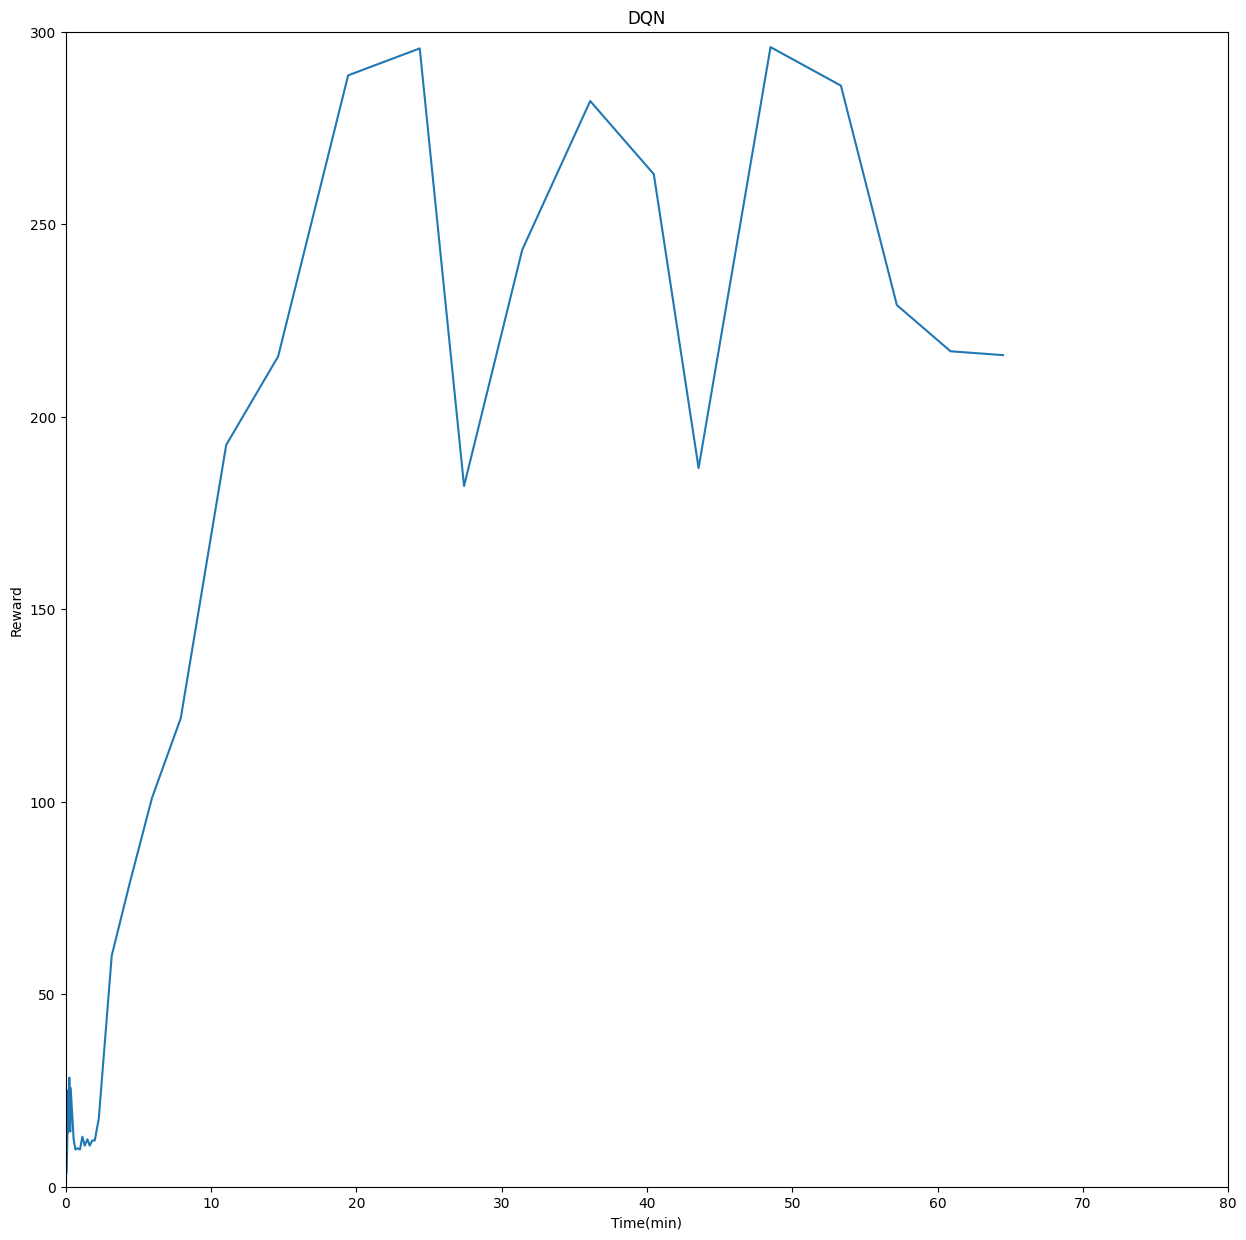

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(Time_tracker,Reward_tracker)
plt.title("DQN")
plt.xlabel('Time(min)')
plt.ylabel('Reward')
plt.ylim(0,300)
plt.xlim(0,80)
plt.show()

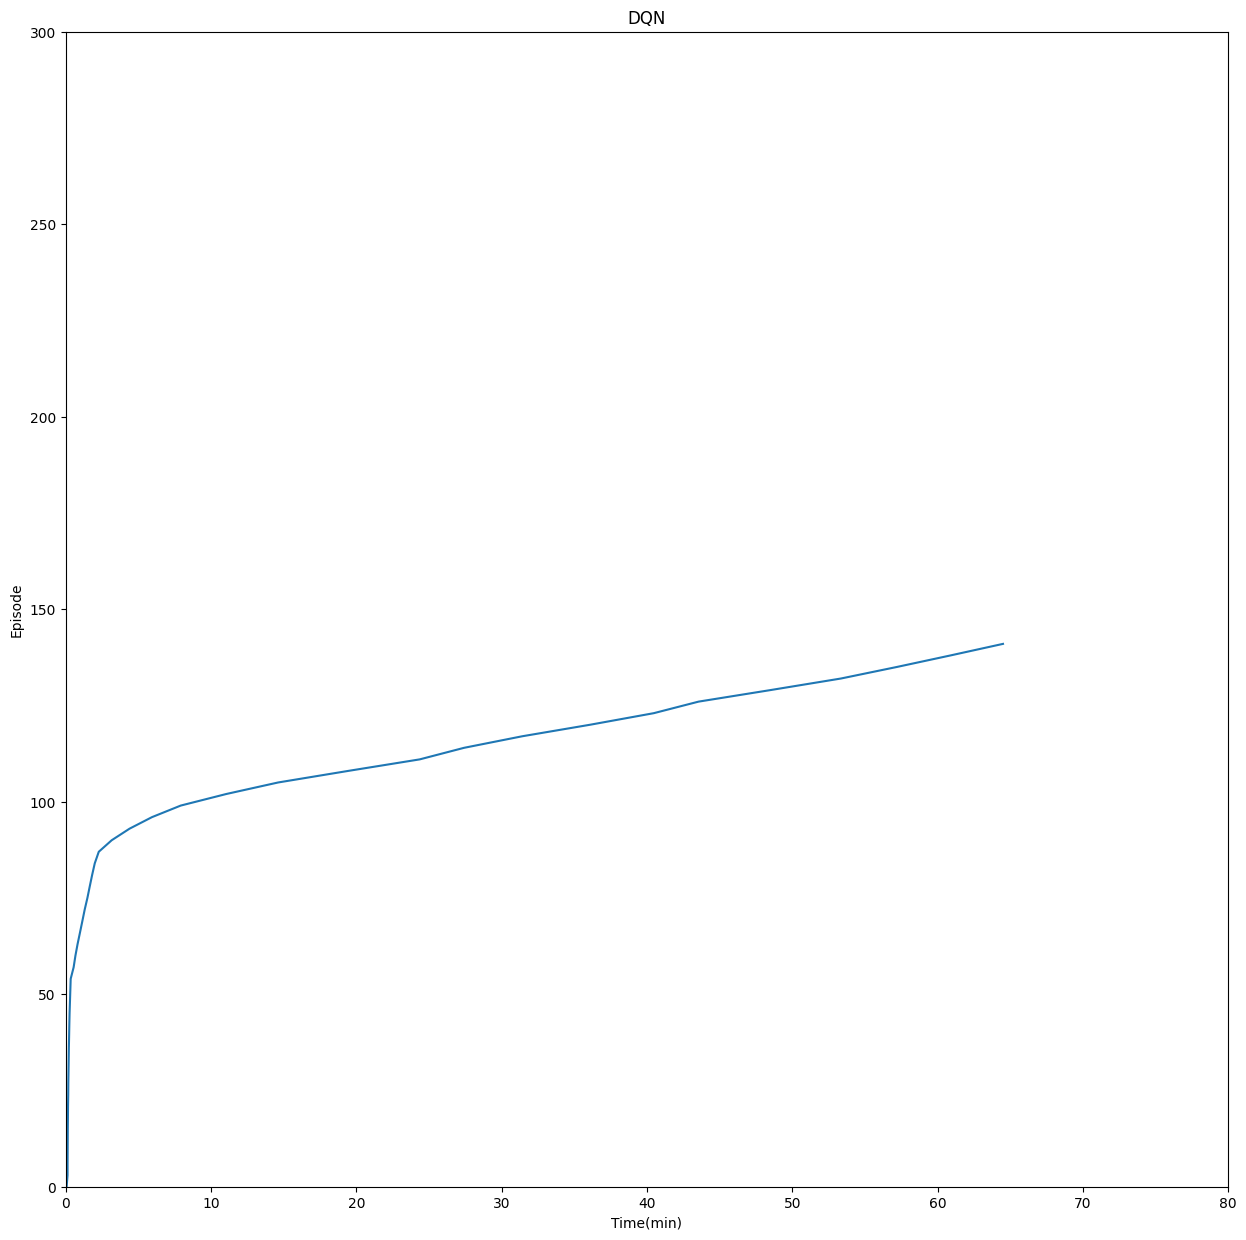

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(Time_tracker,Episode_tracker)
plt.title("DQN")
plt.xlabel('Time(min)')
plt.ylabel('Episode')
plt.ylim(0,300)
plt.xlim(0,80)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers import Lambda

In [ ]:
model1 = keras.Sequential()
model1.add(keras.Input(shape=(110,84,4)))
model1.add(Conv2D(16, (8, 8), strides=(4, 4), padding='valid', activation='relu'))

model1.add(Conv2D(32, (4, 4), strides=(2, 2), padding='valid', activation='relu'))

model1.add(Conv2D(32, (3, 3), strides=(1, 1), padding='valid', activation='relu'))

#model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dropout(0.3))
model1.add(Dense(4, activation='linear'))
    #model1.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 20, 16)        4112      
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 9, 32)         8224      
                                                                 
 conv2d_17 (Conv2D)          (None, 10, 7, 32)         9248      
                                                                 
 flatten_5 (Flatten)         (None, 2240)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               573696    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [ ]:
model2 = keras.Sequential()
model2.add(keras.Input(shape=(210,160,4)))
model2.add(Conv2D(32, (8, 8), strides=(4, 4), padding='valid', activation='relu'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))
model2.add(Conv2D(32, (4, 4), strides=(2, 2), padding='valid', activation='relu'))

#model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
model2.add(Conv2D(32, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
#model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))

model2.add(Dense(4, activation='linear'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 51, 39, 32)        8224      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 8, 32)         16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 6, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 1728)              0         
                                                                 
 dense (Dense)               (None, 256)               442624    
                                                      